# Importo Pacchetti

In [1]:
import numpy as np
import os
import importlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from numba import jit
import nolds
import sys
sys.path.insert(0,'./fortran_package/') # carico la directory con i pacchetti
import maps
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import plotly.graph_objects as go
import plotly.io as pio
import ComputeLE

In [2]:
importlib.reload(maps)

<module 'maps' from './fortran_package/maps.cpython-38-x86_64-linux-gnu.so'>

# Simulo la dinamica

In [6]:
def LV(t, val, a, r):
    """
    Questa funzione definisce gli incrementi secondo il formato utile a 'solve_ivp' di scykit_learn.
    """
    ss = [np.sum(val * i) for i in a]
    diff = [i * x * (1 - s ) for i, x, s in zip(r, val, ss)]
    return diff


def scikit_ivp_solver(t, init, a, r, my_method):
    """
    Chiamo la funzione di IVP ed return degli array con soluzione
    """
    # Chiamata al Solver:
    sol = solve_ivp(LV,            # Funzione con gli incrementi definita sopra
                    [t[0], t[-1]],     # Span di integrazione (intervallo in cui vuoi integrare), ho messo l'intero t
                    init,              # Valori iniziali 
                    t_eval=t,          # Vettore con i tempi in cui vuoi valutare il problema
                    args=[a, r],# Argomenti richiesti dall'IVP 
                    method=my_method,  # Metodo di integrazione (tipo 'RK45', 'Radau',...)
                    max_step = 0.1)  
                                       # Per tutti i metodi visita --> 
    # --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
    
    # I risultati stanno in sol.y
    #x = sol.y[0,:]     # [0,:] indica che prendo tutti i punti in posizione 0
    #y = sol.y[1,:]     # [1,:] indica che prendo tutti i punti in posizione 1
    #z = sol.y[2,:]     # [2,:] indica che prendo tutti i punti in posizione 2
    return sol.y

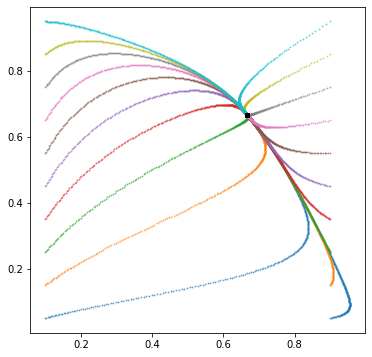

In [7]:
def phase_portrait2(my_method):
    """
    Main per integrare con il metodo my_method (da passare a solve_ivp).
    Restitiusce il plot (da gestire esternamente con plt.show(), ad esempio).
    """
    n = 2000
    t = np.linspace(0, 100, n)
    
    # Parameters
    a = np.array([[1, 0.5],
                  [0.5, 1]])
    r = np.array([0.7, 0.4])
    param = [a, r]
    
    # Inital Values
    #inx = np.arange(0, 1, 0.1)
    inx = np.array([0.1]*10+[0.9]*10)
    iny = np.linspace(0.05,0.95, 10)
    iny = np.concatenate((iny, iny))
    plt.figure(figsize=(6,6))
    for x0, y0 in zip(inx, iny):
        init = [x0, y0]
        s = scikit_ivp_solver(t, init, *param, my_method)
        x = s[0,:]
        y = s[1,:]
        plt.scatter(x, y, s=1, alpha=0.5)
        
    init = [(1-a[0][1])/(1-a[0][1]*a[1][0]), (1-a[1][0])/(1-a[0][1]*a[1][0])]
    s = scikit_ivp_solver(t, init, *param, my_method)
    x = s[0,:]
    y = s[1,:]
    plt.scatter(x, y, s=10, c='k', marker='x')
    plt.show()
phase_portrait2('DOP853')

In [4]:
def main_4initial(my_method, show = False):
    """
    Main per integrare con il metodo my_method (da passare a solve_ivp).
    Restitiusce il plot (da gestire esternamente con plt.show(), ad esempio).
    """
    n = 200000
    t = np.linspace(0, 2000, n)
    
    # Parameters
    a = np.array([[1,    1.09, 1.52, 0   ],
                  [0,    1,    0.44, 1.36],
                  [2.33, 0,    1,    0.47],
                  [1.21, 0.51, 0.35, 1   ]])
    r = np.array([1, 0.72,     1.53, 1.27])
    param = [a, r]
    
    # Inital Values
    #init = [(1-a[0][1])/(1-a[0][1]*a[1][0]), (1-a[1][0])/(1-a[0][1]*a[1][0])]
    init = [0.3, 0.3, 0.1, 0.5]
    
    # Richiamo il "gestore di integrazione"
    s = scikit_ivp_solver(t, init, *param, my_method)
    print(init)
    x = s[0,:]
    y = s[1,:]
    z = s[2,:]
    w = s[3,:]
    if show:
        marker_data = go.Scatter3d(
                        x=x[::10],
                        y=y[::10], 
                        z=z[::10], 
                        marker=go.scatter3d.Marker(size=1, color='blue'), 
                        opacity=0.1, 
                        mode='markers',)
        fig=go.Figure(data=marker_data)
        fig.show()
main_4initial('DOP853')

[0.3, 0.3, 0.1, 0.5]


In [6]:
def confronto(my_method, show = False):
    """
    Main per integrare con il metodo my_method (da passare a solve_ivp).
    Restitiusce il plot (da gestire esternamente con plt.show(), ad esempio).
    """
    n = 200000
    t = np.linspace(0, 2000, n)
    
    # Parameters
    a = np.array([[1,    1.09, 1.52, 0   ],
                  [0,    1,    0.44, 1.36],
                  [2.33, 0,    1,    0.47],
                  [1.21, 0.51, 0.35, 1   ]])
    r = np.array([1, 0.72,     1.53, 1.27])
    param = [a, r]
    
    # Inital Values
    #init = [(1-a[0][1])/(1-a[0][1]*a[1][0]), (1-a[1][0])/(1-a[0][1]*a[1][0])]
    init = [0.3, 0.3, 0.1, 0.5]
    xx = np.ones(n)*init[0]
    yy = np.ones(n)*init[1]
    zz = np.ones(n)*init[2]
    ww = np.ones(n)*init[3]
    #a = a.flatten()
    maps.lv4d(xx, yy, zz, ww, r, a, 0.05, n)
    #plt.plot(xx[:100], alpha=0.4)
    if show:
        marker_data = go.Scatter3d(
                        x=xx[::5],
                        y=yy[::5], 
                        z=zz[::5], 
                        marker=go.scatter3d.Marker(size=1, color='blue'), 
                        opacity=0.1, 
                        mode='markers',)
        fig=go.Figure(data=marker_data)
        fig.show()
confronto('DOP853', show=True)

## Esponenti di Lyapunov

In [6]:
from numba import jit, njit
@njit
def LV(t, val, p):
    """
    Questa funzione definisce gli incrementi secondo il formato utile a 'solve_ivp' di scykit_learn.
    """
    a, r = p
    ss = [np.sum(val * i) for i in a]
    diff = [i * x * (1 - s ) for i, x, s in zip(r, val, ss)]
    return np.array(diff)
@njit
def LVJacc(t, val, p):
    a, r = p
    s = [np.sum(val * i) for i in a]
    J = []
    val_in = 0
    for i in range(len(r)):
        J_in = []
        for j in range(len(r)):
            if i == j: 
                val_in = r[i] * val[i] * (1 - s[i]) - r[i] * val[j] * a[i][j]
            else:
                val_in = - r[i] * val[j] * a[i][j]
            J_in.append(val_in)
        J.append(J_in)
    return np.array(J)

In [19]:
importlib.reload(ComputeLE)
import time

D = 20
np.random.seed(46895045)


a = np.array([[1,    1.09, 1.52, 0   ],
              [0,    1,    0.44, 1.36],
              [2.33, 0,    1,    0.47],
              [1.21, 0.51, 0.35, 1   ]])
r = np.array([1, 0.72,     1.53, 1.27])

param = [a, r]

init = np.array([0.3, 0.3, 0.1, 0.3])


ttrans = np.arange(0.0, 1000, 0.01)
#ttrans = None
t = np.arange(0.0, 1000, 0.01)
start = time.time()
LE, dead = ComputeLE.computeLE(init, t, a, r, ttrans)
print(time.time()-start)
print(LE[-1])

6.175016164779663
[ 0.02884433 -0.00432768 -0.2797042  -1.03013991]


In [3]:
importlib.reload(ComputeLE)
import time
init = np.array([0.3, 0.3, 0.1, 0.3])
n = 100000
ttrans = np.linspace(0, 20000, n)
t = np.linspace(0, 1000, n)
start = time.time()
a, r, LE, save, d = ComputeLE.find_best(init, t, ttrans=ttrans, n = 1000000, seed = 4, patience=200, early_stopping=True)
print(time.time()-start)

[-0.03029468 -0.04542588 -0.20483924 -0.95488218]
[-0.00201585 -0.01862899 -0.16303531 -1.11817265]
[ 0.04677408 -0.02399294 -0.12692052 -1.87110999]
11988.418970108032


Dead Simulation: 933615
Lyapunov Exponent:
 [ 0.04677408 -0.02399294 -0.12692052 -1.87110999]

Parameters:
a:
[[1.         0.98147956 0.79630124 0.68990878]
 [0.53346018 1.         1.02710881 1.12509026]
 [0.47883046 1.1987611  1.         0.55457456]
 [1.06521475 0.76522034 1.00821233 1.        ]]
r:
[1.         2.06934717 2.08471186 1.94137648]

Exponent updated 3 times.


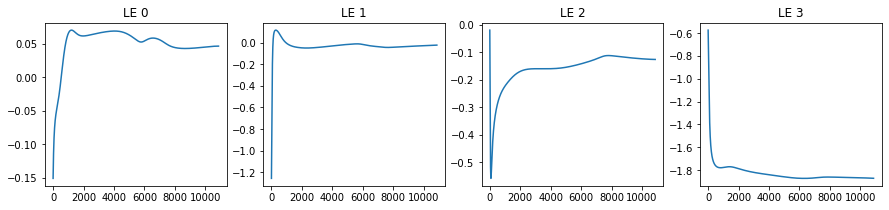

In [4]:
print('Dead Simulation:', d)
print('Lyapunov Exponent:\n', LE[-1])
print(f'\nParameters:\na:\n{a}\nr:\n{r}')
print(f'\nExponent updated {save} times.')
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
for i, (ax, le) in enumerate(zip(axs.flat, LE.T)):
    ax.plot(le)
    ax.set_title(f'LE {i}')

In [7]:
def view(a, r):
    n = 200000
    t = np.linspace(0, 100000, n)
    
    # Inital Values
    init = np.array([0.3, 0.3, 0.1, 0.3])
    x = np.ones((n, 4))*init
    x = ComputeLE.motion(t, x, a, r)
    xx = x[:,0]
    yy = x[:,1]
    zz = x[:,2]
    ww = x[:,3]
    marker_data = go.Scatter3d(
                    x=xx[::100],
                    y=yy[::100], 
                    z=zz[::100], 
                    marker=go.scatter3d.Marker(size=1, color='blue'), 
                    opacity=0.1, 
                    mode='markers',)
    fig=go.Figure(data=marker_data)
    fig.show()
    print(xx[-1], yy[-1], zz[-1], ww[-1])
view(a, r)

0.22083994956383213 0.42651932154353 0.023886625690122447 0.40699154776362517


In [ ]:
"""
--> Cool Periodic Orbit:
    Parameters:
    a:
    [[1.         1.43471146 0.74491111 0.34621858]
     [0.34884148 1.         1.10981946 1.54666483]
     [0.84511431 0.56446351 1.         1.45172517]
     [1.3609575  0.96603015 0.20631601 1.        ]]
    r:
    [1.         0.94391483 1.08315685 1.39923605]
"""